In [1]:
import pandas as pd
import numpy as np
import cv2

In [3]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [4]:
def load_images_to_dataframe(dataset_dir, target_size=(300, 300)):
    data = []
    labels = []

    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Load gambar dan ubah ukuran
                    img = load_img(img_path, target_size=target_size, color_mode="grayscale")
                    img_array = img_to_array(img) / 255.0  # Normalisasi nilai pixel
                    
                    # Cek apakah gambar hitam sepenuhnya
                    if np.all(img_array == 0):
                        print(f"Menghapus gambar hitam: {img_path}")
                        continue  # Lewati gambar hitam
                    
                    data.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Konversi ke DataFrame
    df = pd.DataFrame({
        "image": data,
        "label": labels
    })
    return df


In [5]:
df = load_images_to_dataframe('Training')

In [6]:
df.head()

,image,label
0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",glioma_tumor
1,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",glioma_tumor
2,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",glioma_tumor
3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",glioma_tumor
4,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",glioma_tumor


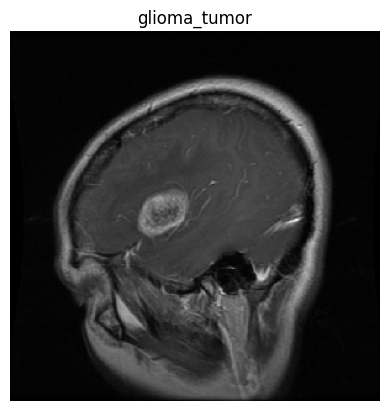

In [7]:
import matplotlib.pyplot as plt

# Ambil gambar pertama dari dataframe
first_image = df.iloc[5]['image']

# Tampilkan gambar menggunakan cv2
plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(df.iloc[7]['label'])
plt.axis('off')
plt.show()

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(4, 4), activation='relu', input_shape=(300, 300, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(filters=64, kernel_size=(4, 4), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 297, 297, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 145, 145, 64)   │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 331776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    42,467,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,501,348 (162.13 MB)

 Trainable params: 42,501,348 (162.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Extract features and labels
X = np.array(df['image'].tolist())
Y = df['label'].values

# Print shapes to verify
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (2870, 300, 300, 1)
Shape of Y: (2870,)


In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Show the mapping
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

# Print the first 10 encoded labels as an example
print("First 10 encoded labels:", Y_encoded[:10])

Label Mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
First 10 encoded labels: [0 0 0 0 0 0 0 0 0 0]


In [13]:
from keras.utils import to_categorical
Y = to_categorical(Y_encoded, num_classes=4)

In [15]:
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
class_weight = {0: 2.0, 1: 1.0, 2: 1.0, 3: 1.5}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
hasil = model.fit(X, Y, epochs=10, batch_size=16, validation_split=0.2, class_weight=class_weight)

Epoch 1/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 140s 964ms/step - accuracy: 0.5375 - loss: 0.6417 - val_accuracy: 0.3937 - val_loss: 0.5445
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8158 - loss: 0.2663 - val_accuracy: 0.3014 - val_loss: 0.8364
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9367 - loss: 0.1182 - val_accuracy: 0.3397 - val_loss: 0.9271
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9678 - loss: 0.0708 - val_accuracy: 0.6167 - val_loss: 0.6863
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9786 - loss: 0.0439 - val_accuracy: 0.3955 - val_loss: 1.2622
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.9815 - loss: 0.0410 - val_accuracy: 0.3920 - val_loss: 1.5000
Epoch 7/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9946 - loss: 0.0168 - val_accuracy: 0.5296 - val_loss: 1.3352
Epoch 8/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.9982 - loss: 0.0125 - val_a

In [16]:
df_t = load_images_to_dataframe('Testing')

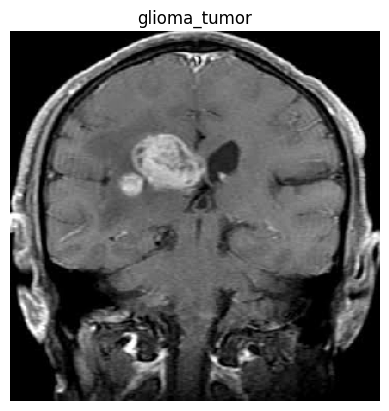

In [95]:
import matplotlib.pyplot as plt

first_image = df_t.iloc[5]['image']

plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(df.iloc[5]['label'])
plt.axis('off')
plt.show()

In [17]:
label_mapping = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
df_t['label']= df_t['label'].map(label_mapping)

In [18]:
X_t = np.array(df_t['image'].tolist())
Y_t = df_t['label'].values

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (2870, 300, 300, 1)
Shape of Y: (2870, 4)


In [19]:
Y_t = to_categorical(Y_t, num_classes=4)

In [20]:
p = model.predict(X_t)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step


In [21]:
from sklearn.metrics import f1_score
from keras.utils import to_categorical

p_labels = np.argmax(p, axis=1)

p_one_hot = to_categorical(p_labels, num_classes=4)

f1 = f1_score(Y_t, p_one_hot, average='weighted')
print("F1-score: ", f1)

F1-score:  0.6727812604212148


In [23]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(np.argmax(Y_t, axis=1), p_labels, target_names=label_mapping.keys())
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.18      0.31       100
meningioma_tumor       0.76      0.96      0.85       115
        no_tumor       0.59      1.00      0.74       105
 pituitary_tumor       0.94      0.69      0.80        74

        accuracy                           0.72       394
       macro avg       0.82      0.71      0.67       394
    weighted avg       0.81      0.72      0.67       394



In [103]:
model.save('model1.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
Tumor: pituitary_tumor
Accuracy: 94.43%


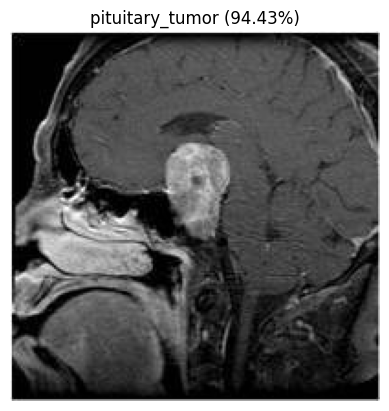

In [1]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

model = load_model('model1.h5')

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

def preprocess_image(image):
    image = cv2.resize(image, (300, 300))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    return image

image_path = 'Testing/pituitary_tumor/image(64).jpg'
image = cv2.imread(image_path)

preprocessed_image = preprocess_image(image)

prediction = model.predict(preprocessed_image)
predicted_label = np.argmax(prediction, axis=1)
predicted_label_name = label_encoder.inverse_transform(predicted_label)[0]
accuracy = np.max(prediction) * 100

print(f'Tumor: {predicted_label_name}')
print(f'Accuracy: {accuracy:.2f}%')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f'{predicted_label_name} ({accuracy:.2f}%)')
plt.axis('off')
plt.show()
